In [1]:
from func import *
import matplotlib.pyplot as plt
from tensorflow import summary as sm
from tensorflow import keras
from keras import models, layers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import datetime
import os
import requests
from openpyxl import Workbook
from scipy.signal import butter, lfilter
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, BatchNormalization 



%load_ext tensorboard

In [2]:
VERSION = 'LSTM LPF'

FILE_00 = 'data.csv'
FILE_01 = 'data1.csv'
FILE_02 = 'data2.csv'
drop_labels_x = ['Data_Point', 'Test_Time(s)', 'Date_Time', 'Step_Time(s)', 'Step_Index', 'Cycle_Index', 'Charge_Capacity(Ah)', 'Discharge_Capacity(Ah)', 'Charge_Energy(Wh)', 'Discharge_Energy(Wh)', 'Internal_Resistance(Ohm)', 'Is_FC_Data','AC_Impedance(Ohm)','ACI_Phase_Angle(Deg)']
drop_labels_y = ['Data_Point', 'Test_Time(s)', 'Date_Time', 'Step_Time(s)', 'Step_Index', 'Cycle_Index', 'Charge_Capacity(Ah)', 'Current(A)', 'Discharge_Capacity(Ah)', 'Charge_Energy(Wh)', 'Discharge_Energy(Wh)', 'dV/dt(V/s)', 'Internal_Resistance(Ohm)', 'Is_FC_Data', 'AC_Impedance(Ohm)','ACI_Phase_Angle(Deg)']

param = {'seq_len' : 10, 'num_units' : 150, 'num_filters' : 128, 'window' : 5, 'dropout': 0.2, 'num_epochs' : 2000, 'num_dense': 80,'batch_size':200} 
batch=500
Fsize=3
log_dir = f"logs/{VERSION}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M") + f'-{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ'
file_path = f'Checkpoints\{VERSION}\SOH_Checkpoint\{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ\{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.h5'
hist_freq = 250

save_path = f'picture\{VERSION}\{Fsize}\{param["num_epochs"]}EP'
try:
    if not os.path.exists(save_path):
        os.makedirs(save_path)
except OSError:
    print('Error Creating Directory...')

Index(['Current(A)', 'Voltage(V)', 'dV/dt(V/s)'], dtype='object')
Index(['Voltage(V)'], dtype='object')
Index(['Current(A)', 'Voltage(V)', 'dV/dt(V/s)'], dtype='object')
Index(['Voltage(V)'], dtype='object')
Index(['Current(A)', 'Voltage(V)', 'dV/dt(V/s)'], dtype='object')
Index(['Voltage(V)'], dtype='object')
data00 = (10000, 3)
data00 = [[3.80853725]
 [3.74783015]
 [3.70217824]
 [3.74621129]
 [3.80157614]
 [3.81209874]]
p =  [-1.38709843  3.74783015  0.00375576]
data00 = <class 'numpy.ndarray'>


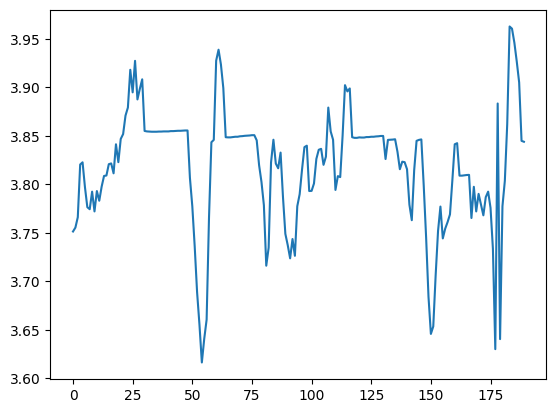

data01 = (10000, 3)


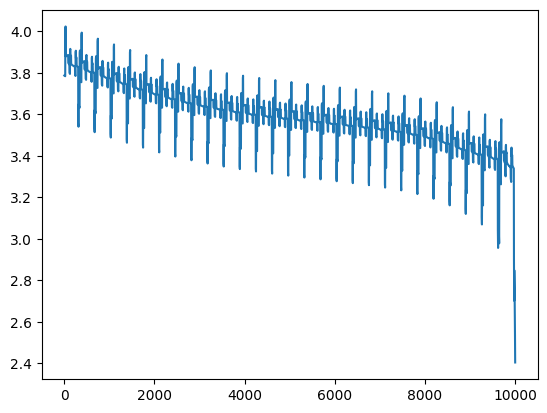

data_test = (10000, 3)


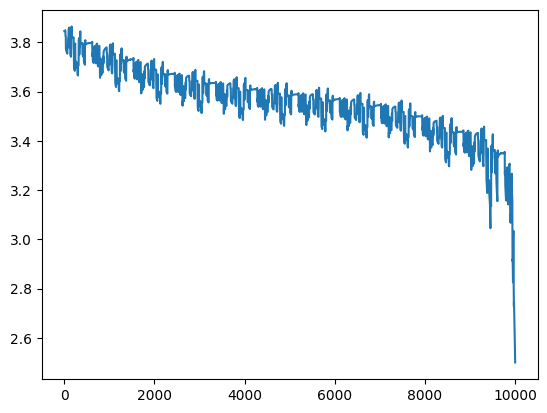

In [3]:
data00, data_cap00 = get_data(FILE_00, drop_labels_x, drop_labels_y)
data01, data_cap01 = get_data(FILE_01, drop_labels_x, drop_labels_y)
data_test, data_cap_test = get_data(FILE_02, drop_labels_x, drop_labels_y)
data00 = data00[3681:]
data_cap00 = data_cap00[3681:]
data01 = data01[2561:]
data_cap01 = data_cap01[2561:]
data_test = data_test[2437:]
data_cap_test = data_cap_test[2437:]
p=0
print(f'data00 = {data00.shape}')
print(f'data00 = {data_cap00[0:6]}')
p=data00[0:5]
print(f'p =  {p[1]}')
print(f'data00 = {type(data_cap00)}')
pl.plot(data_cap00[10:200])
pl.show()
print(f'data01 = {data01.shape}')
pl.plot(data_cap01)
pl.show()
print(f'data_test = {data_test.shape}')
pl.plot(data_cap_test)
pl.show()
savedata00 =  data00
savedata_cap00 =  data_cap00
savedata01 =  data01
savedata_cap01 =  data_cap01
savedata_test = data_test
savedata_cap_test = data_cap_test

In [4]:
# mMscaler = MinMaxScaler(feature_range=(0.0001, 1))
# data00= mMscaler.fit_transform(data00)
# data_cap00= mMscaler.fit_transform(data_cap00)
# data01= mMscaler.fit_transform(data01)
# data_cap01= mMscaler.fit_transform(data_cap01)
# data_test= mMscaler.fit_transform(data_test)
# data_cap_test= mMscaler.fit_transform(data_cap_test)




In [5]:
# for i in range(0,10):
#     param['num_units']=param['num_units']+80
#     model = models.Sequential()
#     model.add(layers.Conv1D(param['num_filters'], param['window'], padding='causal', input_shape = (None, x_train00.shape[-1])))
#     model.add(layers.GRU(param['num_units'], return_sequences = True, input_shape = (None, x_train00.shape[-1])))
#     model.add(layers.TimeDistributed(layers.Dense(param['num_dense'])))
#     model.add(layers.TimeDistributed(layers.Dense(1)))
#     model.compile(loss = 'mse', optimizer = 'Adam') 
#     model.summary()
#     callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
#                           TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
#     fitdata = model.fit(x_train00, y_train00, epochs=param['num_epochs'], verbose = 0, validation_split = 0.2, callbacks=callback_list)
#     callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
#                          TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
#     fitdata = model.fit(x_train01, y_train01, epochs=param['num_epochs'], verbose = 0, validation_split = 0.2, callbacks=callback_list)
#     print(param['num_units'])
#     RMSE, MAE, Error_rate = show_and_prove(model, file_path, x_test, y_test, save_path, return_loss=True)
#     print(f'RMSE({RMSE:.6f}), MAE({MAE:.6f})')

In [6]:
# data00 = data00[Fsize//2:data00.shape[0]-Fsize//2]
# data_cap00 = data_cap00[Fsize//2:data_cap00.shape[0]-Fsize//2]
# data01 = data01[Fsize//2:data01.shape[0]-Fsize//2]
# data_cap01 = data_cap01[Fsize//2:data_cap01.shape[0]-Fsize//2]
# data_test = data_test[Fsize//2:data_test.shape[0]-Fsize//2]
# data_cap_test = data_cap_test[Fsize//2:data_cap_test.shape[0]-Fsize//2]

In [7]:
# print(f'data00 = {data00.shape}')
# print(f'data_cap00 = {data_cap00.shape}')
# print(f'data00 = {data_cap00[0:6]}')
# print(f'data00 = {type(data_cap00)}')
# pl.plot(data_cap00)
# pl.show()
# print(f'data01 = {data01.shape}')
# pl.plot(data_cap01)
# pl.show()
# print(f'data_test = {data_test.shape}')
# pl.plot(data_cap_test)
# pl.show()

In [8]:
data00 = lowpass1(data00, Fsize)[Fsize:]
data_cap00 = lowpass1(data_cap00,Fsize)[Fsize:]
data01 = lowpass1(data01,Fsize)[Fsize:]
data_cap01 = lowpass1(data_cap01,Fsize)[Fsize:]
data_test = lowpass1(data_test,Fsize)[Fsize:]
data_cap_test = lowpass1(data_cap_test,Fsize)[Fsize:]
size=(int)(savedata00.shape[0]-Fsize/2)
savedata00 =  savedata00[Fsize:size]
savedata_cap00 =  savedata_cap00[Fsize:size]
savedata01 =  savedata01[Fsize:size]
savedata_cap01 =  savedata_cap01[Fsize:size]
savedata_test = savedata_test[Fsize:size]
savedata_cap_test = savedata_cap_test[Fsize:size]

print(f'data00 = {data00.shape}')
print(f'savedata00 = {savedata_cap_test.shape}')

data00 = (9992, 3)
savedata00 = (9992, 1)


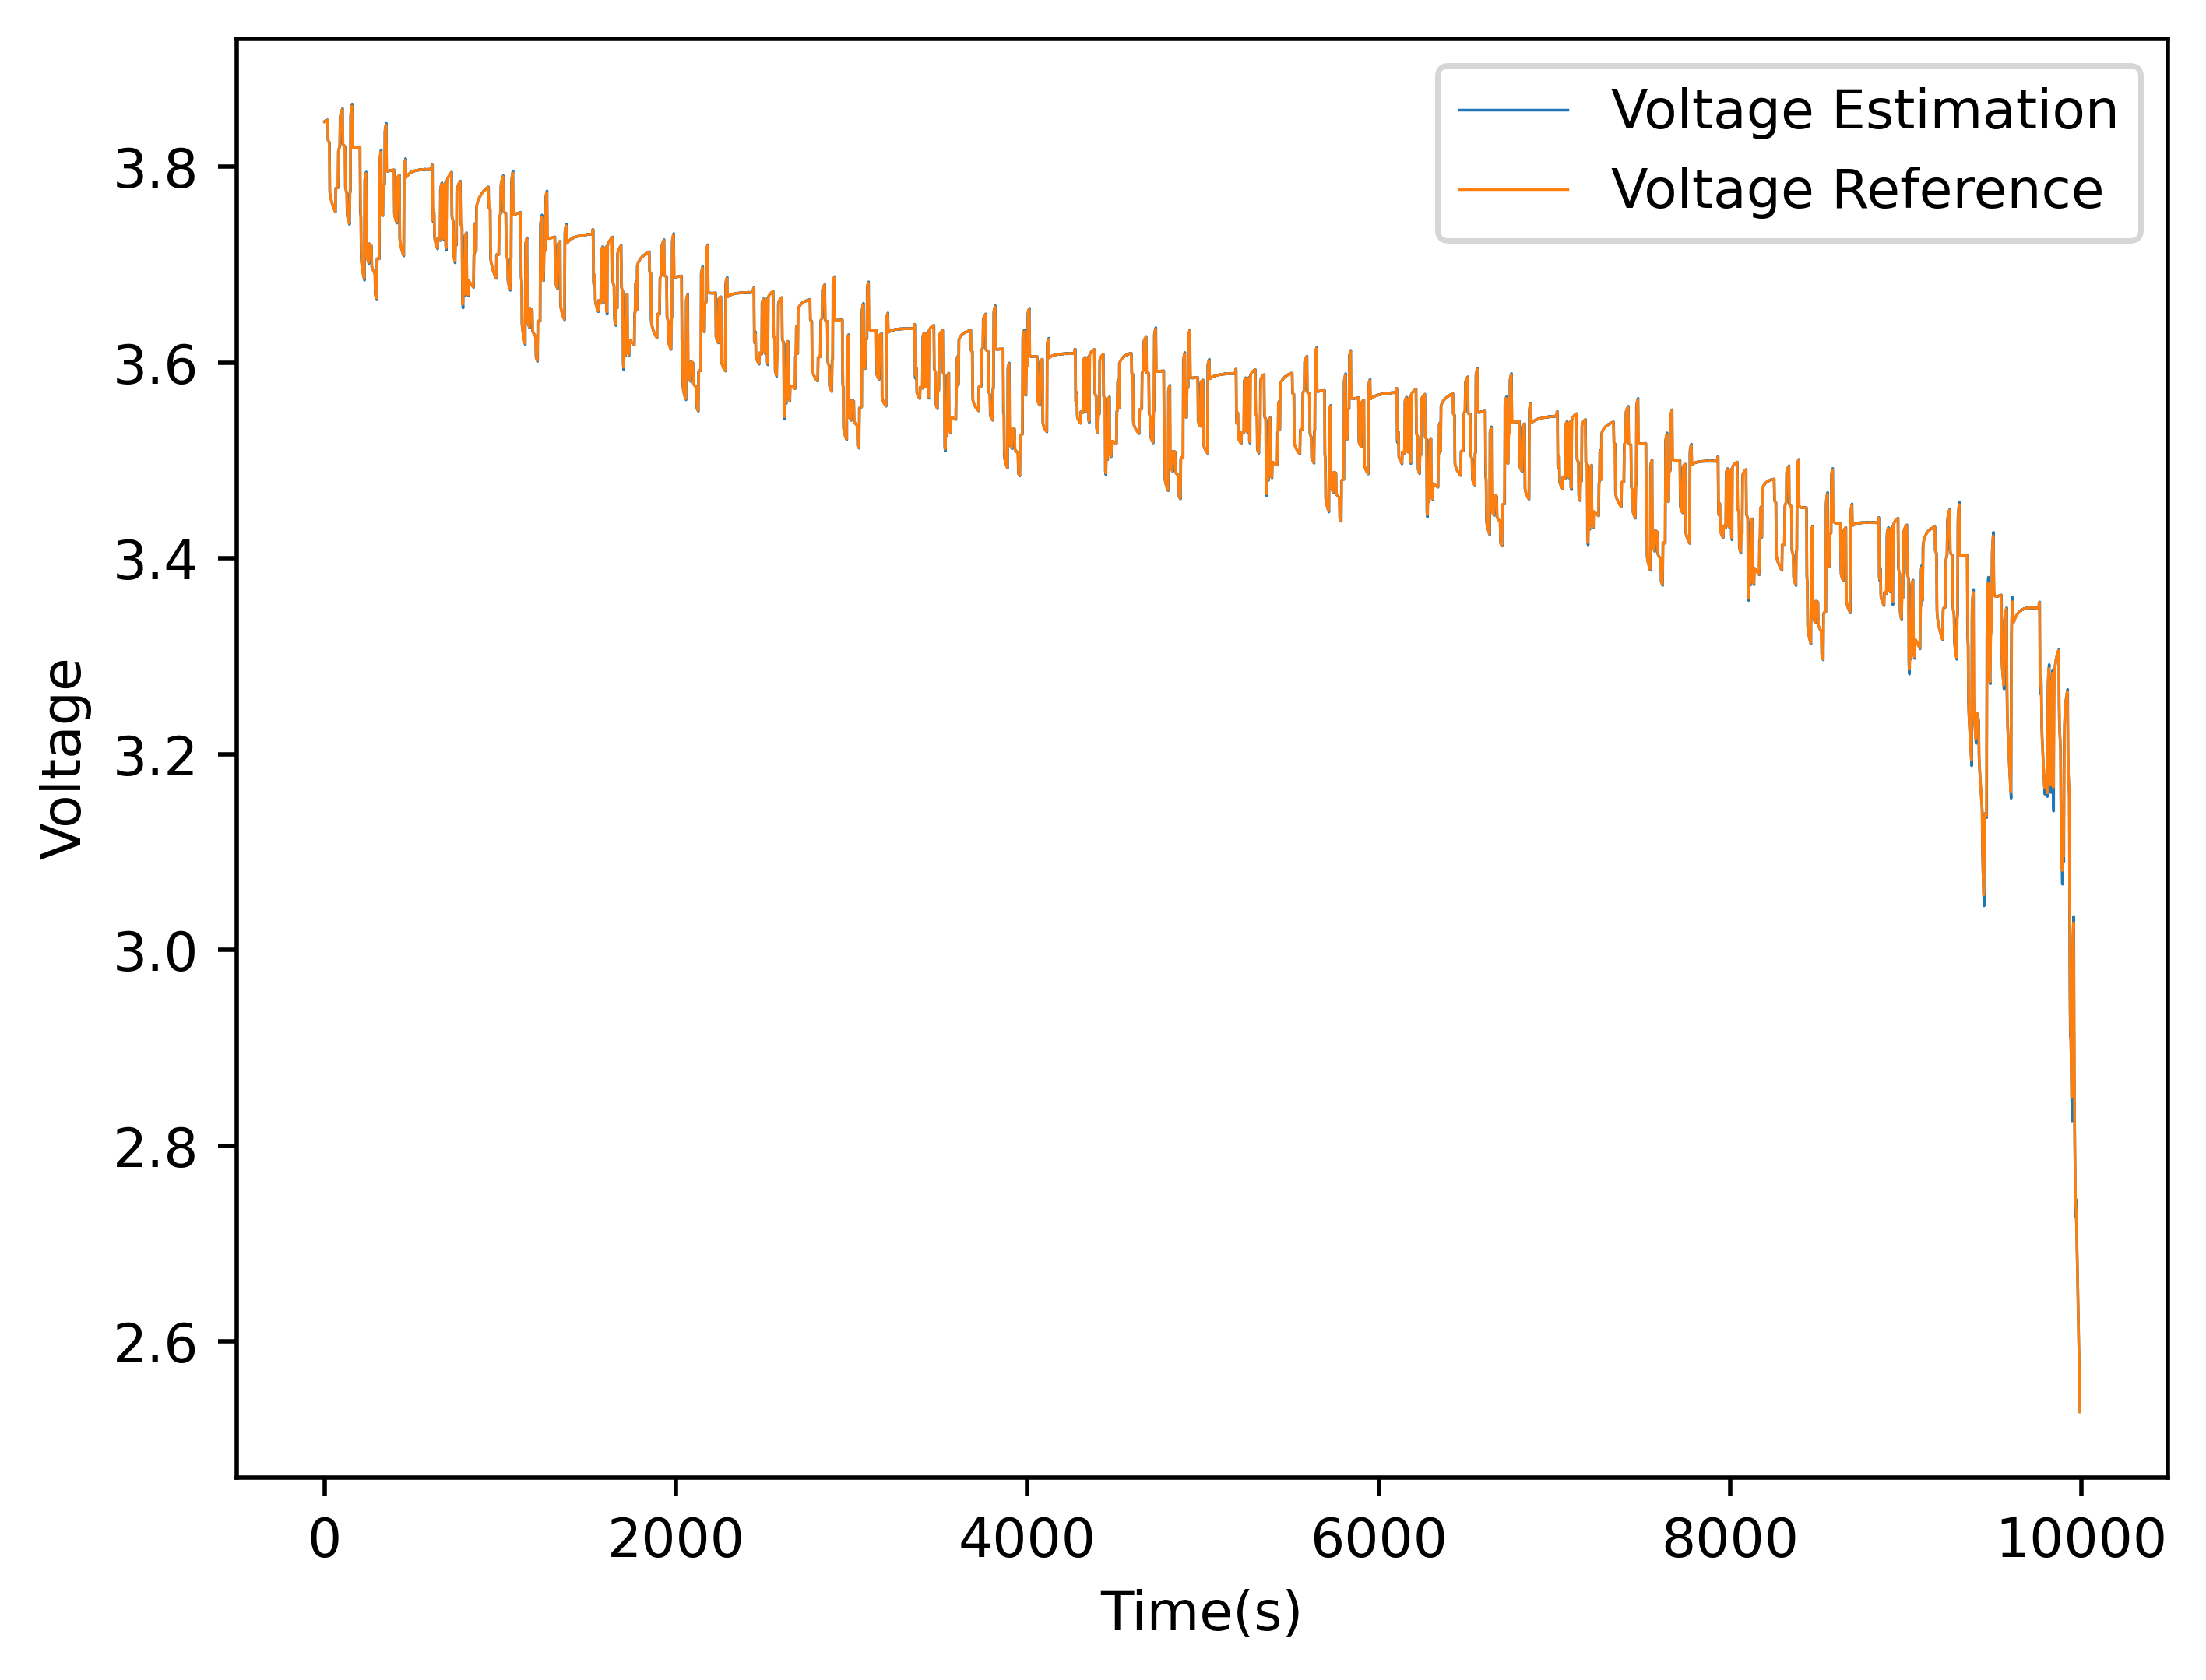

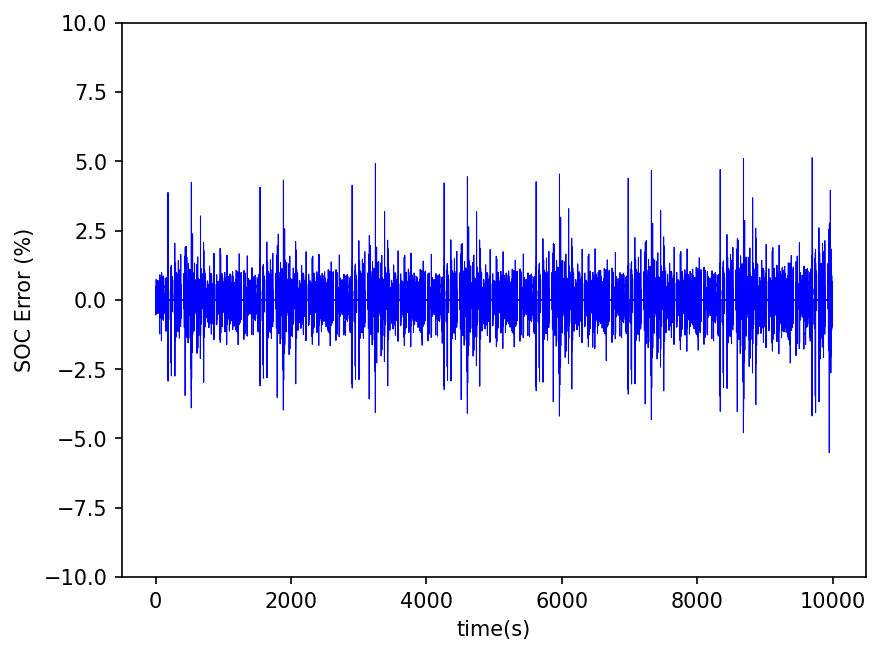

RMSE(0.006912), MAE(0.004400)


In [9]:
pl.figure(dpi=500)
pl.ylabel('Voltage')
pl.xlabel('Time(s)')
line = pl.plot(savedata_cap_test, label = 'Voltage Estimation')
pl.setp(line, linewidth=0.5)

y_line = pl.plot(data_cap_test, label = 'Voltage Reference')
# y_line = pl.plot(y_graph, label = 'Voltage Reference')
pl.setp(y_line, linewidth=0.5)
pl.legend()
pl.savefig(f'{save_path}\Estimation.png')
pl.show()

Error_rate = []
Error = []

for step in range(len(savedata_cap00)):
        # Error_rate.append((prediction_graph[step] - savedata_cap_test[step]) / savedata_cap_test[step] * 100)
        Error_rate.append((savedata_cap00[step] - data_cap00[step]) / savedata_cap00[step] * 100)
        Error.append(Error_rate[step] / 100)
    

RMSE_total = np.sqrt(np.mean(np.square(Error)))
MAE_total = np.mean(np.absolute(Error))
pl.figure(dpi=150)
line = pl.plot(Error_rate)
pl.ylim(-10, 10)
pl.ylabel('SOC Error (%)')
pl.xlabel('time(s)')
pl.setp(line, color='b', linewidth=0.5)

pl.show()
print(f'RMSE({RMSE_total:.6f}), MAE({MAE_total:.6f})')

In [10]:
x_train00 = seq_gen_x(data00, param['seq_len'])
y_train00 = seq_gen_y(data_cap00, param['seq_len'])
x_train01 = seq_gen_x(data01, param['seq_len'])
y_train01 = seq_gen_y(data_cap01, param['seq_len'])
x_test = seq_gen_x(data_test, param['seq_len'])
y_test = seq_gen_y(data_cap_test, param['seq_len'])
print(x_train00.shape)
print(y_train00.shape)
# print(x_train00[0, 0:6, 1])
# count=savedata_cap_test.shape[0]-y_test.shape[0]*y_test.shape[1]
# print(count)

(9981, 10, 3)
(9981, 1)


In [11]:
print(x_train00.shape[-1])

3


In [12]:
model = models.Sequential()
# model.add(layers.Conv1D(param['num_filters'], param['window'], padding='causal', input_shape = (None, x_train00.shape[-1])))
model.add(layers.LSTM(param['num_units'], return_sequences = True, input_shape = (None, x_train00.shape[-1])))
# BatchNormalization()
model.add(layers.LSTM(16))
# BatchNormalization()
model.add(layers.Dense(param['num_dense']))
# BatchNormalization()
model.add(layers.Dense(1))
model.compile(loss = 'mse', optimizer = 'Adam') 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 150)         92400     
                                                                 
 lstm_1 (LSTM)               (None, 16)                10688     
                                                                 
 dense (Dense)               (None, 80)                1360      
                                                                 
 dense_1 (Dense)             (None, 1)                 81        
                                                                 
Total params: 104,529
Trainable params: 104,529
Non-trainable params: 0
_________________________________________________________________


In [13]:
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                      TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train00, y_train00, epochs=param['num_epochs'], verbose = 1, validation_split = 0.2, callbacks=callback_list ,batch_size=param['batch'])
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                     TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train01, y_train01, epochs=param['num_epochs'], verbose = 1, validation_split = 0.2, callbacks=callback_list,batch_size=param['batch'])


Epoch 1/2000
250/250 [==============================] - 5s 7ms/step - loss: 0.3032 - val_loss: 0.0497
Epoch 2/2000
250/250 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 0.0348
Epoch 3/2000
250/250 [==============================] - 1s 5ms/step - loss: 0.0074 - val_loss: 0.0421
Epoch 4/2000
250/250 [==============================] - 1s 5ms/step - loss: 0.0069 - val_loss: 0.0293
Epoch 5/2000
250/250 [==============================] - 1s 5ms/step - loss: 0.0058 - val_loss: 0.0360
Epoch 6/2000
250/250 [==============================] - 1s 5ms/step - loss: 0.0027 - val_loss: 0.0091
Epoch 7/2000
250/250 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 8/2000
250/250 [==============================] - 1s 5ms/step - loss: 5.6010e-04 - val_loss: 0.0010
Epoch 9/2000
250/250 [==============================] - 1s 4ms/step - loss: 4.0993e-04 - val_loss: 0.0011
Epoch 10/2000
250/250 [==============================] - 1s 4ms/step - los

In [14]:
# EP=0
# datas=[]
# for i in range(0,5):
#     EP=EP+param["num_epochs"]
#     callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
#                  TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
#     fitdata = model.fit(x_train00, y_train00, epochs=param['num_epochs'], verbose = 0, validation_split = 0.2, callbacks=callback_list,batch_size=200)
#     callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
#                  TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
#     fitdata = model.fit(x_train01, y_train01, epochs=param['num_epochs'], verbose = 0, validation_split = 0.2, callbacks=callback_list,batch_size=200)
#     RMSE, MAE, Error_rate = show_and_prove(model, file_path, x_test, y_test, save_path, return_loss=True)
#     print(f'RMSE({RMSE:.6f}), MAE({MAE:.6f})','EP =',EP)
#     datas.append(data=[EP,RMSE,MAE],columns=['epoch','RMSE','MAE'])

# write_wb = Workbook()
# write_ws = write_wb.create_sheet('결과')
# for data in datas:
#     write_ws.append(data)

# write_wb.save(r'C:/Users/Administrator/Desktop/python/excel/export_sample.xlsx')
# RMSE, MAE, Error_rate = show_and_prove(model, file_path, x_test, y_test, save_path, return_loss=True)

In [15]:
# #필터 안적용시
# from calendar import EPOCH
# print(x_test.shape)
# print(y_test.shape)
# # x_test = mMscaler.inverse_transform(x_test)
# # y_test = mMscaler.inverse_transform(y_test)
# RMSE_total, MAE_total, Error_rate, prediction_graph, y_graph = prove(model, file_path, x_test, y_test)
# # prediction_graph = mMscaler.inverse_transform(prediction_graph)
# # y_graph = mMscaler.inverse_transform(y_graph)
# print(prediction_graph.shape)
# print(y_test.shape)
# print('......')
# print(save_path)
# # prediction_graph=relow(prediction_graph, savedata_cap_test, Fsize)
# # savedata_cap_test=savedata_cap_test[Fsize:]
# print(prediction_graph.shape)
# print(y_graph.shape)
# pl.figure(dpi=500)
# pl.ylabel('Voltage')
# pl.xlabel('Time(s)')
# line = pl.plot(prediction_graph[5000:6000], label = 'Voltage Estimation')
# pl.setp(line, linewidth=0.5)

# # y_line = pl.plot(savedata_cap_test, label = 'Voltage Reference')
# y_line = pl.plot(y_graph, label = 'Voltage Reference')
# pl.setp(y_line, linewidth=0.5)
# pl.legend()
# pl.savefig(f'{save_path}\Estimation.png')
# pl.show()

In [16]:
# #필터 안적용시
# Error_rate = []
# Error = []

# for step in range(len(prediction_graph)):
#         # Error_rate.append((prediction_graph[step] - savedata_cap_test[step]) / savedata_cap_test[step] * 100)
#         Error_rate.append((prediction_graph[step] - y_graph[step]) / y_graph[step] * 100)
#         Error.append(Error_rate[step] / 100)
    

# RMSE_total = np.sqrt(np.mean(np.square(Error)))
# MAE_total = np.mean(np.absolute(Error))
# pl.figure(dpi=150)
# line = pl.plot(Error_rate)
# pl.ylim(-10, 10)
# pl.ylabel('SOC Error (%)')
# pl.xlabel('time(s)')
# pl.setp(line, color='b', linewidth=0.5)
# pl.show()
# print(f'RMSE({RMSE_total:.6f}), MAE({MAE_total:.6f})')

In [20]:
#필터적용시
from calendar import EPOCH

RMSE_total, MAE_total, Error_rate, prediction_graph, y_graph = prove(model, file_path, x_test, y_test)
print(prediction_graph.shape)
print(y_graph.shape)
print(savedata_cap_test.shape)
print('......')
prediction_graph=relow3(prediction_graph, y_graph, Fsize)
lsize=(int)(y_graph.shape[0]-Fsize/2)
prediction_graph=prediction_graph[Fsize:]
y_graph=y_graph[Fsize:lsize]

print(prediction_graph.shape)
print(y_graph.shape)

312/312 [==============================] - 1s 2ms/step
(9981, 1)
(9981, 1)
(9992, 1)
......
(9973, 1)
(9973, 1)


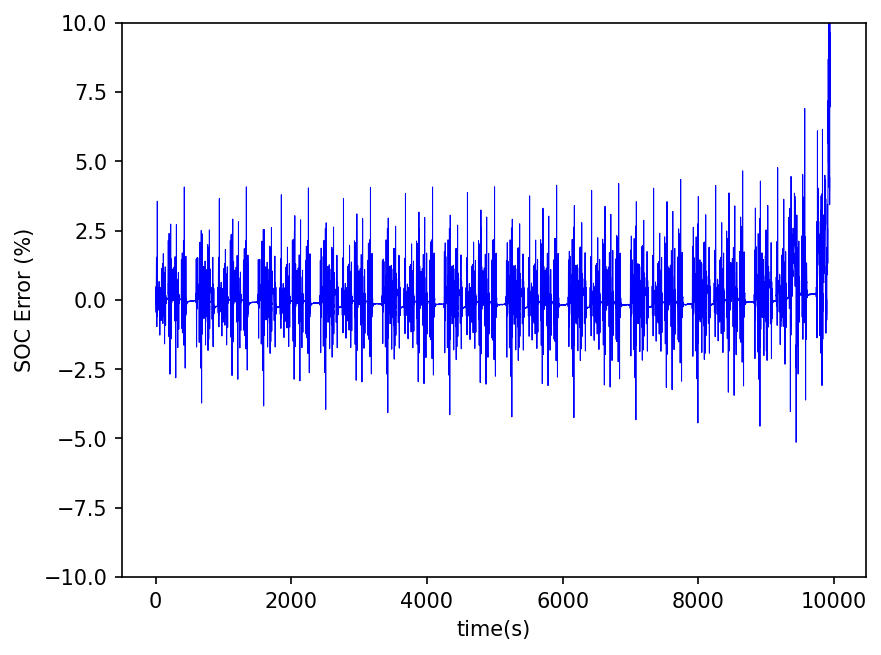

RMSE(0.012949), MAE(0.005332)


In [21]:
#필터 적용시
Error_rate = []
Error = []

for step in range(len(prediction_graph)):
        Error_rate.append((prediction_graph[step] - y_graph[step]) / y_graph[step] * 100)
        # Error_rate.append((prediction_graph[step] - y_graph[step]) / y_graph[step] * 100)
        Error.append(Error_rate[step] / 100)
    

RMSE_total = np.sqrt(np.mean(np.square(Error)))
MAE_total = np.mean(np.absolute(Error))
pl.figure(dpi=150)
line = pl.plot(Error_rate)
pl.ylim(-10, 10)
pl.ylabel('SOC Error (%)')
pl.xlabel('time(s)')
pl.setp(line, color='b', linewidth=0.5)
pl.savefig(f'{save_path}\RMSE {RMSE_total:.6f},MAE {MAE_total:.6f}.png')
pl.show()
print(f'RMSE({RMSE_total:.6f}), MAE({MAE_total:.6f})')

In [ ]:
pl.figure(dpi=500)
pl.ylabel('Voltage')
pl.xlabel('Time(s)')
line = pl.plot(prediction_graph, label = 'Voltage Estimation')
pl.setp(line, linewidth=0.5)

# y_line = pl.plot(savedata_cap_test, label = 'Voltage Reference')
y_line = pl.plot(y_graph, label = 'Voltage Reference')
pl.setp(y_line, linewidth=0.5)
pl.legend()
pl.savefig(f'{save_path}\ESTI RMSE {RMSE_total:.6f},MAE {MAE_total:.6f}.png')
pl.show()

In [19]:
print(prediction_graph.shape)
print(y_graph.shape)

(9973, 1)
(9973, 1)
